In [1]:
import sklearn
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly import tools
import numpy as np
from numpy import newaxis
import cv2

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from PIL import Image

# Set notebook mode to work in offline
pyo.init_notebook_mode()

### Collect 30 images from internet, 15 from Sergio Ramos, and another 15 from Luka Modric and store it in a directory called 'Dataset'. 
#### The images are displayed below:

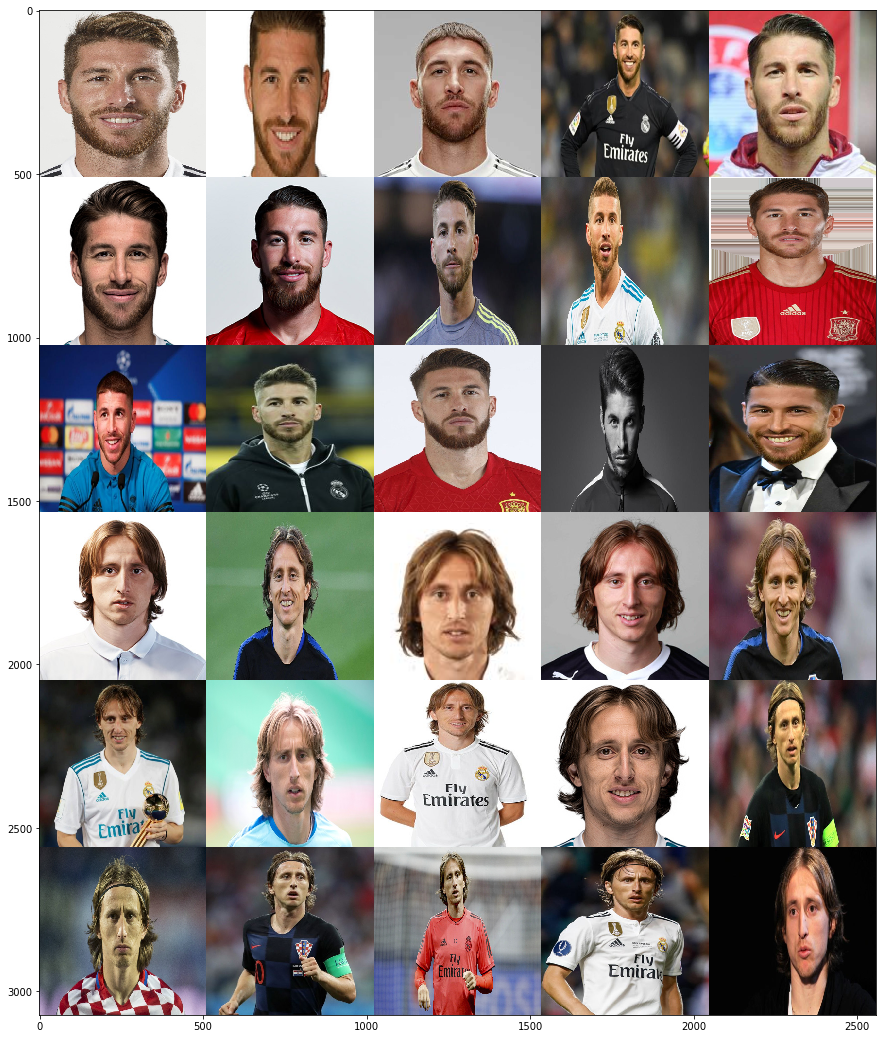

In [2]:
image_list = ['Ramos_'+str(i+1)+'.jpg' for i in range(15)]+['Modric_'+str(i+1)+'.jpg' for i in range(15)] #Name of the images

images = []
for i in range(30):
    image = cv2.imread('Dataset\\'+image_list[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #By default imread reads the images in BGR space, so convert it into RGB
    image = cv2.resize(image,(512,512)) #Resize the images in order to plot it well. This will cause some images to be stretched
    images.append(image)

h1 = np.hstack((images[0],images[1],images[2],images[3],images[4]))
h2 = np.hstack((images[5],images[6],images[7],images[8],images[9]))
h3 = np.hstack((images[10],images[11],images[12],images[13],images[14]))
h4 = np.hstack((images[15],images[16],images[17],images[18],images[19]))
h5 = np.hstack((images[20],images[21],images[22],images[23],images[24]))
h6 = np.hstack((images[25],images[26],images[27],images[28],images[29]))
all_images = np.vstack((h1,h2,h3,h4,h5,h6))
plt.figure(figsize=(15,20))
plt.imshow(all_images)

### Extract the faces of the images using haarcascade_frontalface_default.xml

In [3]:
face_size = 100 #Faces will be resized 100 x 100 pixels
NUM_EIGEN_FACES = 20 # Number of EigenFaces
face_list = ['Ramos_Face_'+str(i+1)+'.jpg' for i in range(15)]+['Modric_Face_'+str(i+1)+'.jpg' for i in range(15)] #Face names

# Create the haar cascade
faceCascade = cv2.CascadeClassifier('Haarcascades\haarcascade_frontalface_default.xml')

for i in range(30):
    # Read the image
    image = cv2.imread('Dataset\\'+image_list[i])
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #Convert the images to grayscale

    # Detect faces in the image
    faces = faceCascade.detectMultiScale(gray,scaleFactor=1.1,minNeighbors=5,minSize=(30, 30),flags = cv2.CASCADE_SCALE_IMAGE)

    x = faces[0][0] #Select only the first face detected by haarcascade_frontalface_default
    y = faces[0][1]
    w = faces[0][2]
    h = faces[0][3]
    #crop_face = gray[y-20:y+h+30, x-20:x+w+30]
    crop_face = gray[y:y+h, x:x+w]
    crop_face = cv2.resize(crop_face, (face_size, face_size)) 
    image_name = 'Dataset\Processed_Dataset\\'+face_list[i]
    cv2.imwrite(image_name, crop_face)

### The extracted faces are in the directory 'Dataset\Processed_Dataset'. The faces are displayed below:

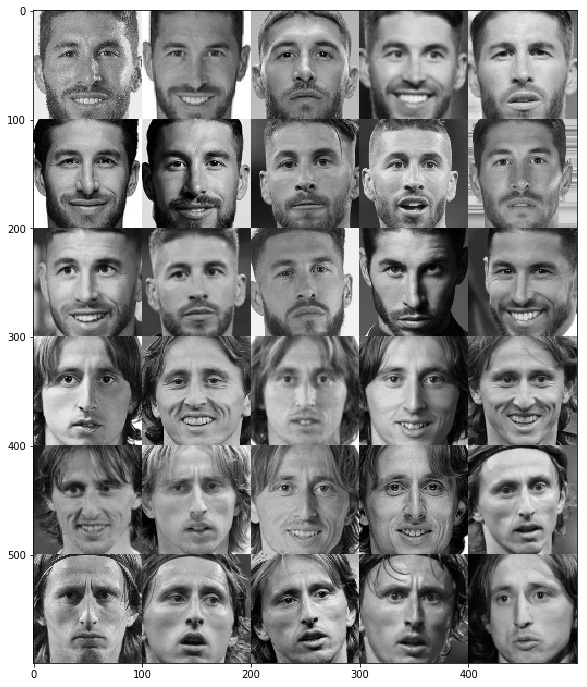

In [4]:
face_list = ['Ramos_Face_'+str(i+1)+'.jpg' for i in range(15)]+['Modric_Face_'+str(i+1)+'.jpg' for i in range(15)] #Face names

faces = []
for i in range(30):
    face = cv2.imread('Dataset\Processed_Dataset\\'+face_list[i])
    faces.append(face)

h1 = np.hstack((faces[0],faces[1],faces[2],faces[3],faces[4]))
h2 = np.hstack((faces[5],faces[6],faces[7],faces[8],faces[9]))
h3 = np.hstack((faces[10],faces[11],faces[12],faces[13],faces[14]))
h4 = np.hstack((faces[15],faces[16],faces[17],faces[18],faces[19]))
h5 = np.hstack((faces[20],faces[21],faces[22],faces[23],faces[24]))
h6 = np.hstack((faces[25],faces[26],faces[27],faces[28],faces[29]))
all_faces = np.vstack((h1,h2,h3,h4,h5,h6))
plt.figure(figsize=(10,12))
plt.imshow(all_faces)

### Get the data that is needed for classification. 
### For training data, first 10 images of both Sergio Ramos & Luka Modric is considered. 
### For testing data, last 5 images of both Sergio Ramos & Luka Modric is considered

In [5]:
face_list_names = ['Ramos_Face_'+str(i+1)+'.jpg' for i in range(15)]+['Modric_Face_'+str(i+1)+'.jpg' for i in range(15)]
face_list = list()
for i in range(30):
    processed_face = Image.open(r'''Dataset\Processed_Dataset\\'''+face_list_names[i])
    processed_face = np.array(processed_face.getdata())
    face_list.append(processed_face)

X = np.array(face_list)
X_train = np.concatenate((X[:10],X[15:25]),axis=0)
X_test = np.concatenate((X[10:15],X[25:30]),axis=0)
y_train = np.array([0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1],dtype='int64')
y_test = np.array([0,0,0,0,0,1,1,1,1,1],dtype='int64')
target_names = np.array(['Sergio Ramos', 'Luka Modric'], dtype='<U17')
n_classes = 2
w = 100
h = 100

## Apply PCA

In [6]:
n_components = 10

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 10 eigenfaces from 20 faces
done in 0.038s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.003s


In [7]:
X_train.shape

(20, 10000)

In [8]:
X_train_pca.shape
#PCA reduced the dimensions of the images from 25600 to only 10!

(20, 10)

### Display the Eigenfaces

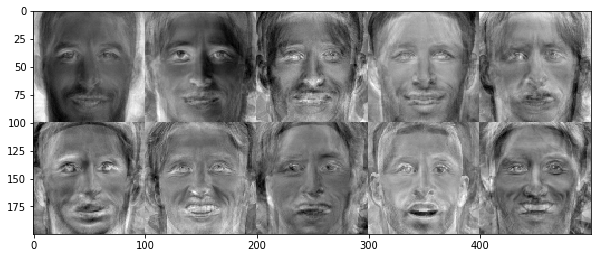

In [9]:
def process_eigenfaces(eigenfaces):
    process_eigenfaces = []
    for i in range(len(eigenfaces)):
        eigenFace = eigenfaces[i]
        eigenFace = ((eigenFace - eigenFace.min()) * (1/(eigenFace.max() - eigenFace.min()) * 255)).astype('uint8')
        eigenFace = cv2.cvtColor(eigenFace, cv2.COLOR_BGR2RGB)
        process_eigenfaces.append(eigenFace)
    return process_eigenfaces

processed_efs = process_eigenfaces(eigenfaces)

h1 = np.hstack((processed_efs[0],processed_efs[1],processed_efs[2],processed_efs[3],processed_efs[4]))
h2 = np.hstack((processed_efs[5],processed_efs[6],processed_efs[7],processed_efs[8],processed_efs[9]))
efaces = np.vstack((h1,h2))
plt.figure(figsize=(10,12))
plt.imshow(efaces)

### Face Feature Plot Using PCA Reduction of Images to 2D Space

In [10]:
n_components_2d = 2
pca_2d = PCA(n_components=n_components_2d, svd_solver='randomized',
          whiten=True).fit(X_train)
X_train_pca_2d = pca_2d.transform(X_train)
X_test_pca_2d = pca_2d.transform(X_test)

def pca_2d_reshape(pca_2d):
    pca_2d_reshape = []
    for i in range(len(pca_2d)):
        pca_i = pca_2d[i]
        pca_i = (pca_i*1024).astype('int8')+256
        pca_2d_reshape.append(pca_i)
    return pca_2d_reshape

X_train_pca_2d_reshape = pca_2d_reshape(X_train_pca_2d)
X_test_pca_2d_reshape = pca_2d_reshape(X_test_pca_2d)

Text(0, 0.5, 'PCA Component 2')

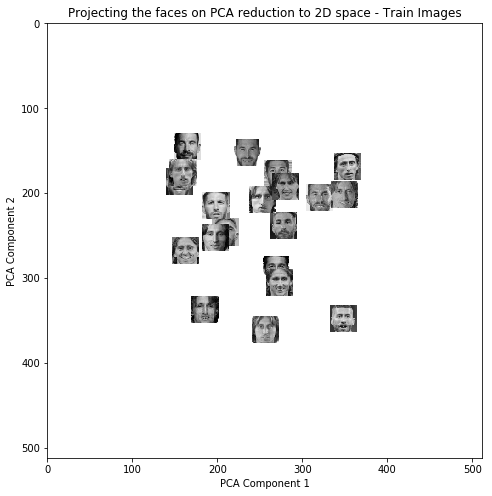

In [11]:
#Face Feature Plot Using PCA reduction on images to 2D - Train Data
img = np.zeros([512,512],dtype=np.uint8)
img.fill(255) 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
train_faces = faces[0:10]+faces[15:25]
for i in range(20):
    train_f = train_faces[i]
    train_f = cv2.resize(train_f,(32,32)) #Faces will be bit blurred as we are resizing from (100,100) to (32,32)
    x = X_train_pca_2d_reshape[i][0]
    y = X_train_pca_2d_reshape[i][1]
    h = 32
    w = 32
    img[y:y+h, x:x+w] = train_f
plt.figure(figsize=(8,8))
plt.imshow(img)
plt.title('Projecting the faces on PCA reduction to 2D space - Train Images')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

Text(0, 0.5, 'PCA Component 2')

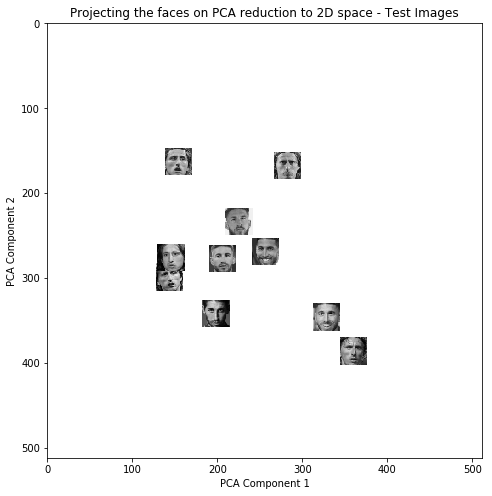

In [12]:
#Face Feature Plot Using PCA reduction on images to 2D - Test Data
img = np.zeros([512,512],dtype=np.uint8)
img.fill(255) 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
test_faces = faces[10:15]+faces[25:30]
for i in range(10):
    test_f = test_faces[i]
    test_f = cv2.resize(test_f,(32,32)) #Faces will be bit blurred as we are resizing from (100,100) to (32,32)
    x = X_test_pca_2d_reshape[i][0]
    y = X_test_pca_2d_reshape[i][1]
    h = 32
    w = 32
    img[y:y+h, x:x+w] = test_f
plt.figure(figsize=(8,8))
plt.imshow(img)
plt.title('Projecting the faces on PCA reduction to 2D space - Test Images')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

## Face Classification using SVM

In [13]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)


Fitting the classifier to the training set
done in 0.111s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


C:\Users\Triguna\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning:

You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.

C:\Users\Triguna\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



In [14]:
print("Predicting people's names on the test set")
t0 = time()
y_pred_SVM = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred_SVM, target_names=target_names))
print(confusion_matrix(y_test, y_pred_SVM, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.000s
              precision    recall  f1-score   support

Sergio Ramos       0.71      1.00      0.83         5
 Luka Modric       1.00      0.60      0.75         5

   micro avg       0.80      0.80      0.80        10
   macro avg       0.86      0.80      0.79        10
weighted avg       0.86      0.80      0.79        10

[[5 0]
 [2 3]]


In [15]:
def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []
    
    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])
        
    return pl_colorscale


def plot_gallery(images, titles, h, w, n_row=2, n_col=5):
    """Helper function to plot a gallery of portraits"""
    subplot_title= []
    for i in range(n_row * n_col):
        subplot_title.append(titles[i])
        
    
    fig = tools.make_subplots(rows=n_row, cols=n_col, print_grid=False,
                          subplot_titles=tuple(subplot_title))
    trace_list=[ ]
    
    for i in range(n_row * n_col):
        trace = go.Heatmap(
                           z=images[i].reshape((h, w)),
                           showscale=False,
                           colorscale=matplotlib_to_plotly(plt.cm.gray, 300)
                          )
        trace_list.append(trace)
    
    fig.append_trace(trace_list[0], 1, 1)
    fig.append_trace(trace_list[1], 1, 2)
    fig.append_trace(trace_list[2], 1, 3)
    fig.append_trace(trace_list[3], 1, 4)
    fig.append_trace(trace_list[4], 1, 5)
    fig.append_trace(trace_list[5], 2, 1)
    fig.append_trace(trace_list[6], 2, 2)
    fig.append_trace(trace_list[7], 2, 3)
    fig.append_trace(trace_list[8], 2, 4)
    fig.append_trace(trace_list[9], 2, 5)
    
    for i in list(map(str,range(1,11))):
        y = 'yaxis'+ i
        x = 'xaxis'+i
        fig['layout'][y].update(autorange='reversed',
                                   showticklabels=False, ticks='')
        fig['layout'][x].update(showticklabels=False, ticks='')
        
    #fig['layout'].update(height=1000)
    return fig


def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s<br>true:      %s' % (pred_name, true_name)

In [16]:
prediction_titles = [title(y_pred_SVM, y_test, target_names, i)
                     for i in range(y_pred_SVM.shape[0])]
h = 100
w = 100
#pyo.iplot(plot_gallery(X_test, prediction_titles, h, w)) #Enable it to plot it on your local device

<img src="Images\SVM_predictions_iplot.png">

## Face Classification using Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier
criterion = ["entropy","gini"]
min_weight_fraction_leaf = [0.001, 0.0025, 0.005, 0.0075, 0.009, 0.01]
class_weight=['balanced','balanced_subsample', None]
n_estimators = [10, 25, 50, 100, 250]
max_features = ['auto', 'sqrt', 'log2', None]
bootstrap = [True, False]
random_state = [0]
n_jobs=[1]
min_samples_leaf = [0.1, 0.2, 0.3, 0.4, 0.5]
min_samples_split = [0.1, 0.25, 0.5, 0.75, 0.9, 1.0]
param_grid = {'criterion': criterion,
               'min_weight_fraction_leaf':min_weight_fraction_leaf,
               'class_weight':class_weight,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'bootstrap': bootstrap,
               'random_state': random_state,
               'n_jobs':n_jobs,
               'min_samples_leaf': min_samples_leaf,
               'min_samples_split': min_samples_split}

#clf = RandomizedSearchCV(RandomForestClassifier(), param_grid, n_iter = 500, cv = 5)
clf = RandomForestClassifier(bootstrap=False, class_weight='balanced',criterion='entropy', max_depth=None, max_features=None,
                             max_leaf_nodes=None, min_impurity_decrease=0.0,min_impurity_split=None, min_samples_leaf=0.3,
                             min_samples_split=0.5, min_weight_fraction_leaf=0.0025,n_estimators=100, n_jobs=1, 
                             oob_score=False, random_state=0,verbose=0, warm_start=False)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
#print("Best estimator found by random search:")
#print(clf.best_estimator_)

print("Predicting people's names on the test set")
t0 = time()
y_pred_RF = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred_RF, target_names=target_names))
print(confusion_matrix(y_test, y_pred_RF, labels=range(n_classes)))

done in 0.924s
Predicting people's names on the test set
done in 0.005s
              precision    recall  f1-score   support

Sergio Ramos       1.00      0.40      0.57         5
 Luka Modric       0.62      1.00      0.77         5

   micro avg       0.70      0.70      0.70        10
   macro avg       0.81      0.70      0.67        10
weighted avg       0.81      0.70      0.67        10

[[2 3]
 [0 5]]


In [18]:
prediction_titles = [title(y_pred_RF, y_test, target_names, i)
                     for i in range(y_pred_RF.shape[0])]

#pyo.iplot(plot_gallery(X_test, prediction_titles, h, w)) #Enable it to plot it on your local device

<img src="Images\RF_predictions_iplot.png">

## Face Classification using Multi Layer Perceptron

In [19]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier()
clf = clf.fit(X_train_pca, y_train)

print("Predicting people's names on the test set")
t0 = time()
y_pred_MLP = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred_MLP, target_names=target_names))
print(confusion_matrix(y_test, y_pred_MLP, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.000s
              precision    recall  f1-score   support

Sergio Ramos       0.80      0.80      0.80         5
 Luka Modric       0.80      0.80      0.80         5

   micro avg       0.80      0.80      0.80        10
   macro avg       0.80      0.80      0.80        10
weighted avg       0.80      0.80      0.80        10

[[4 1]
 [1 4]]


C:\Users\Triguna\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



In [20]:
prediction_titles = [title(y_pred_MLP, y_test, target_names, i)
                     for i in range(y_pred_MLP.shape[0])]

#pyo.iplot(plot_gallery(X_test, prediction_titles, h, w)) #Enable it to plot it on your local device

<img src="Images\MLP_predictions_iplot.png">

## Face Classification using Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression
#Hyper-parameter tuning for Logistic Regression using RamdomizedSearchCV
tol=[0.001,0.01, 0.1,0.0001]
c = [1.0,2.0,5.0,10.0]
fit_intercept = [True,False]
intercept_scaling = [1,2,3,4,5]
class_weight = ['balanced',None]
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
max_iter = [50,100,200]
param_grid = {'tol': tol,
               'C': c,
               'fit_intercept': fit_intercept,
               'intercept_scaling': intercept_scaling,
               'class_weight': class_weight,
               'solver': solver,
               'max_iter': max_iter}
#clf = RandomizedSearchCV(LogisticRegression(), param_grid, n_iter = 500, cv = 3)
clf = LogisticRegression(C=1.0, class_weight='balanced', dual=False,fit_intercept=False, intercept_scaling=3, max_iter=50,
                         multi_class='warn', n_jobs=None, penalty='l2', random_state=None,solver='lbfgs', tol=0.0001)
clf = clf.fit(X_train_pca, y_train)
#print("Best estimator found by random search:")
#print(clf.best_estimator_)

print("Predicting people's names on the test set")
t0 = time()
y_pred_LogitR = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred_LogitR, target_names=target_names))
print(confusion_matrix(y_test, y_pred_LogitR, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.000s
              precision    recall  f1-score   support

Sergio Ramos       0.71      1.00      0.83         5
 Luka Modric       1.00      0.60      0.75         5

   micro avg       0.80      0.80      0.80        10
   macro avg       0.86      0.80      0.79        10
weighted avg       0.86      0.80      0.79        10

[[5 0]
 [2 3]]


In [22]:
prediction_titles = [title(y_pred_LogitR, y_test, target_names, i)
                     for i in range(y_pred_LogitR.shape[0])]

#pyo.iplot(plot_gallery(X_test, prediction_titles, h, w))  #Enable it to plot it on your local device

<img src="Images\LR_predictions_iplot.png">

#### Overall SVM, MLP, & Logistic Regression produced the best performance correctly classifying 8 out of 10 faces